In [1]:
import requests
import pandas as pd 
from fbprophet import Prophet

In [2]:
mensa_suffix = "mg"
from_date = "00:00_20190911"
url = "http://graphite-kom.srv.lrz.de/render?target=transformNull(sumSeries(exclude(ap.ap*-?{mensa}*.ssid.*,\"ssid\\.error$\")))&format=json&from={date}".format(mensa=mensa_suffix, date=from_date)
json = requests.get(url).json()

In [3]:
datapoints = json[0]["datapoints"]

In [4]:
df = pd.DataFrame(datapoints)
df[1], df[0] = df[0], df[1]
df = df.rename(columns={0:"ds",1:"y"})
df["ds"] = pd.to_datetime(df["ds"],unit='s')

In [5]:
df.head(10)

,ds,y
0,2019-09-10 22:15:00,0.0
1,2019-09-10 22:30:00,0.0
2,2019-09-10 22:45:00,0.0
3,2019-09-10 23:00:00,0.0
4,2019-09-10 23:15:00,0.0
5,2019-09-10 23:30:00,0.0
6,2019-09-10 23:45:00,0.0
7,2019-09-11 00:00:00,0.0
8,2019-09-11 00:15:00,0.0
9,2019-09-11 00:30:00,0.0


In [6]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [7]:
future = m.make_future_dataframe(periods=30)

In [8]:
future.tail()

,ds
27390,2020-07-17 23:15:00
27391,2020-07-18 23:15:00
27392,2020-07-19 23:15:00
27393,2020-07-20 23:15:00
27394,2020-07-21 23:15:00


In [9]:
forecast = m.predict(future)

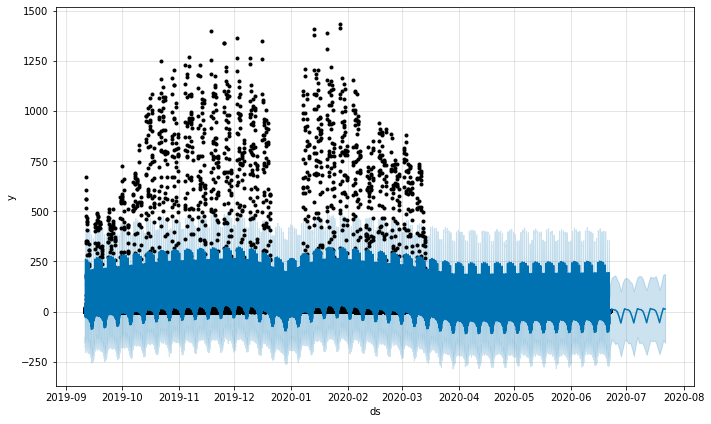

In [10]:
fig1 = m.plot(forecast)

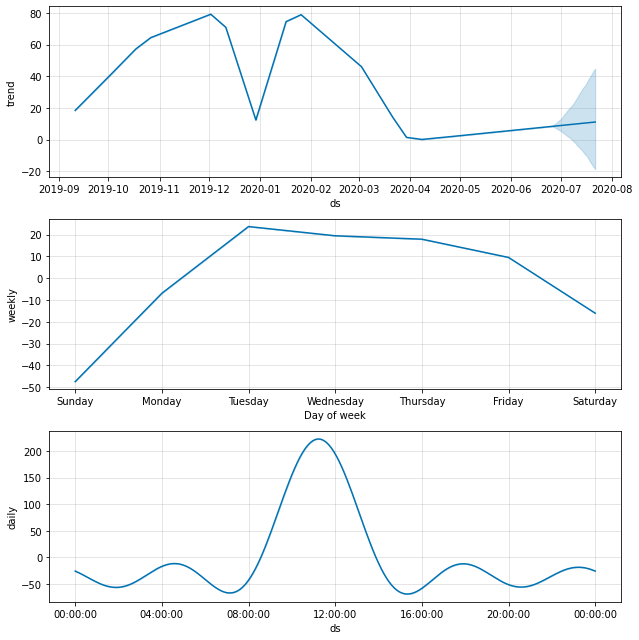

In [11]:
fig2 = m.plot_components(forecast)